## Requirements

In [43]:
!pip install parti-pytorch
!pip install datasets
!pip install transformers
!pip install sentencepiece

Mounting Google Drive to use FFHQ dataset

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training of VQ-GAN VAE transformer (1st stage)

I reduced the size of the image to make it a simpler training for the model. Additionally, patch_size and num_layers were increased trying to improve performance.
The code needs the right paths for dataset and results.

In [52]:
from parti_pytorch import VitVQGanVAE, VQGanVAETrainer

vit_vae = VitVQGanVAE(
    dim = 128,               # dimensions
    image_size = 128,        # target image size
    patch_size = 12,         # size of the patches in the image attending to each other
    num_layers = 4           # number of layers
).cuda()

trainer = VQGanVAETrainer(
    vit_vae,
    folder = '/path/to/ffhq_dataset/',
    num_train_steps = 1250,
    lr = 3e-4,
    batch_size = 8,
    grad_accum_every = 8,
    save_model_every = 250,
    save_results_every = 250,
    amp = True,
    results_folder = '/path/to/results/'
)

11283 training samples found at /content/drive/MyDrive/thumbnails
training with dataset of 10718 samples and validating with randomly splitted 565 samples
do you want to clear previous experiment checkpoints and results? (y/n) 


Number of parameters for the model during first stage:

In [53]:
sum(p.numel() for p in vit_vae.parameters())

163483585

Approximately one epoch of training:

In [54]:
trainer.train()

0: vae loss: 1.1786454170942307 - discr loss: 213.77776527404785
0: saving to /content/drive/MyDrive/thumbnails/results
0: saving model to /content/drive/MyDrive/thumbnails/results
1: vae loss: 0.463151928037405 - discr loss: 192.49103355407715
2: vae loss: 0.5020251870155334 - discr loss: 225.6923885345459
3: vae loss: 0.4820970259606838 - discr loss: 196.90873336791992
4: vae loss: 0.4610333517193794 - discr loss: 214.85802841186523
5: vae loss: 0.42755331844091415 - discr loss: 208.7263011932373
6: vae loss: 0.40534063428640366 - discr loss: 201.7298069000244
7: vae loss: 0.3746955394744873 - discr loss: 202.2490119934082
8: vae loss: 0.34611791744828224 - discr loss: 8.845327854156494
9: vae loss: 0.3213726729154587 - discr loss: 8.78696584701538
10: vae loss: 0.31733207032084465 - discr loss: 3.303292989730835
11: vae loss: 0.30384311079978943 - discr loss: 3.5114537477493286
12: vae loss: 0.27739308029413223 - discr loss: 4.202036559581757
13: vae loss: 0.2754332050681114 - discr

KeyboardInterrupt: ignored

## Load VQ-GAN VAE into Parti and train for text to image generation.

In the repo, they suggest using ema VAE's weights, however, that state_dict contains diffferent key names to the ones requested by VitVQGanVAE. I tried changing the names to fit the needs of it, however, I didn't see any improvement from there so I prefered to play it safe with vae.pt state_dict.

Update path to results_folder

In [55]:
import torch
state_dict = torch.load('/path/to/results/')

I modified the code slightly to use a large patch_size, smaller image_size and more layers.

In [56]:
import torchvision.transforms as transforms
from datasets import load_dataset
from parti_pytorch import Parti, VitVQGanVAE

transform = transforms.Compose([
    transforms.PILToTensor()
])


vit_vae = VitVQGanVAE(
    dim = 128,               # dimensions
    image_size = 128,        # target image size
    patch_size = 12,         # size of the patches in the image attending to each other
    num_layers = 4           # number of layers
).cuda()

vit_vae.load_state_dict(state_dict) # you will want to load the exponentially moving averaged VAE


parti = Parti(
    vae = vit_vae,            # vit vqgan vae
    dim = 128,                # model dimension
    depth = 12,                # depth
    dim_head = 64,            # attention head dimension
    heads = 8,                # attention heads
    dropout = 0.,             # dropout
    cond_drop_prob = 0.25,    # conditional dropout, for classifier free guidance
    ff_mult = 5,              # feedforward expansion factor
    t5_name = 't5-large',     # name of your T5
)

dataset = load_dataset("cr7Por/ffhq_controlnet_5_2_23")


  0%|          | 0/1 [00:00<?, ?it/s]

I trained for more than one epoch to try to improve the results. I added some code to use FFHQ_controlnet dataset

In [66]:
from parti_pytorch.t5 import t5_encode_text
from tqdm.notebook import tqdm

epochs=2

for _ in range(epochs):
    batch_size = 8
    total_samples = 39600
    num_batches = (total_samples + batch_size - 1) // batch_size  # Calculate the total number of batches


    for batch_idx in tqdm(range(num_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, total_samples)

        batch_texts = dataset['train'][start_idx:end_idx]['image_caption']
        batch_images = [transform(image.resize((128, 128))) for image in dataset['train'][start_idx:end_idx]['image']]
        batch_images = torch.stack(batch_images).to(torch.float32).cuda()

        text_token_embeds, text_mask = t5_encode_text(batch_texts, name = 't5-large', output_device = batch_images.device)

        loss = parti(
            text_token_embeds = text_token_embeds,
            text_mask = text_mask,
            images = batch_images,
            return_loss = True
        )

        loss.backward()

  0%|          | 0/4950 [00:00<?, ?it/s]

Number of parameters for model during 2nd stage:

In [67]:
sum(p.numel() for p in parti.parameters())

169586593

Add the right path to save the state_dict

In [68]:
torch.save(parti.state_dict(), '/path/to/store/parti_state_dict/parti.pt')

In [69]:
images = parti.generate(texts = [
    'an old man smiling wearing a hat',
    'young girl blowing out candles on her birthday cake',
    'a kid with long hair and red hair',
    'blue',
    'red'
], cond_scale = 3., return_pil_images = True)

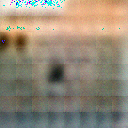

In [70]:
display(images[0])

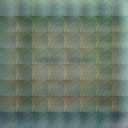

In [71]:
display(images[1])

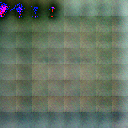

In [72]:
display(images[2])

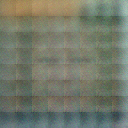

In [73]:
display(images[3])

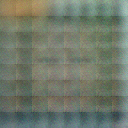

In [74]:
display(images[4])

As observed, the images are not great. However, since in the first stage, the model was only trained on one epoch and in this second stage, the model was only trained on two epochs, it hurts the performance significantly. In order to see the true potential of the model (results published), more epochs, more data must be used and more parameters need to be used.